# Additional Data Insights

This notebook explores interesting patterns and relationships in the asthma, emissions, and mortality data.

In [2]:
pip install pandas numpy matplotlib seaborn scipy


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data
asthma_df = pd.read_csv('./AsthmaTotals.csv')
emissions_df = pd.read_csv('./emissions.csv')
mortality_df = pd.read_csv('./Mortality-Rates-by-State.csv', header=1)

## 1. Regional Analysis

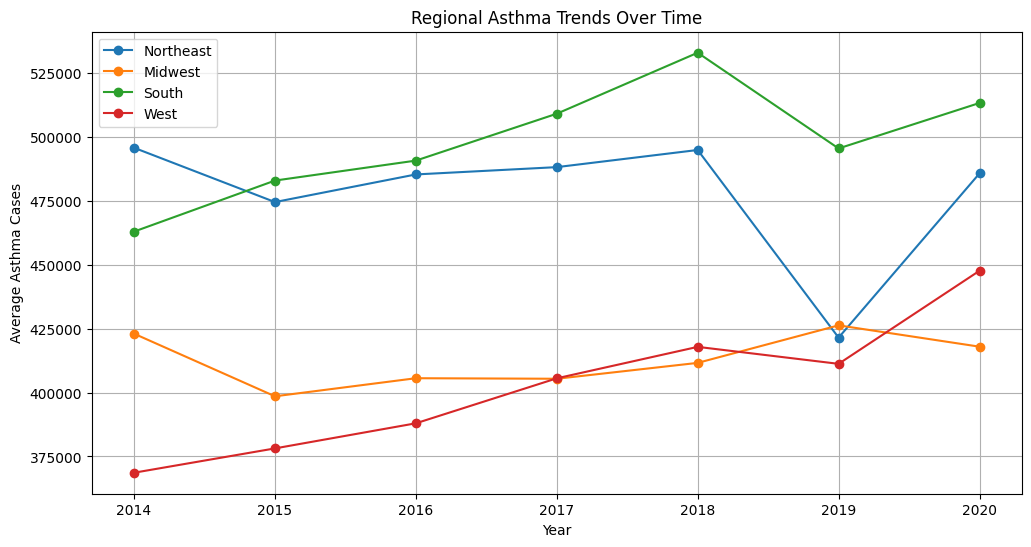

In [2]:
# Define regions
regions = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey'],
    'Midwest': ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa'],
    'South': ['Delaware', 'Maryland', 'Virginia', 'West Virginia', 'Kentucky', 'North Carolina', 'South Carolina', 'Tennessee', 'Georgia', 'Florida', 'Alabama', 'Mississippi', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']
}

# Add region column to dataframes
def add_region(state):
    for region, states in regions.items():
        if state in states:
            return region
    return 'Other'

asthma_df['Region'] = asthma_df['State'].apply(add_region)

# Calculate regional averages
regional_asthma = asthma_df.groupby(['Region', 'Year'])['Total'].mean().reset_index()

# Plot regional trends
plt.figure(figsize=(12, 6))
for region in regions.keys():
    data = regional_asthma[regional_asthma['Region'] == region]
    plt.plot(data['Year'], data['Total'], marker='o', label=region)

plt.title('Regional Asthma Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Asthma Cases')
plt.legend()
plt.grid(True)
plt.show()

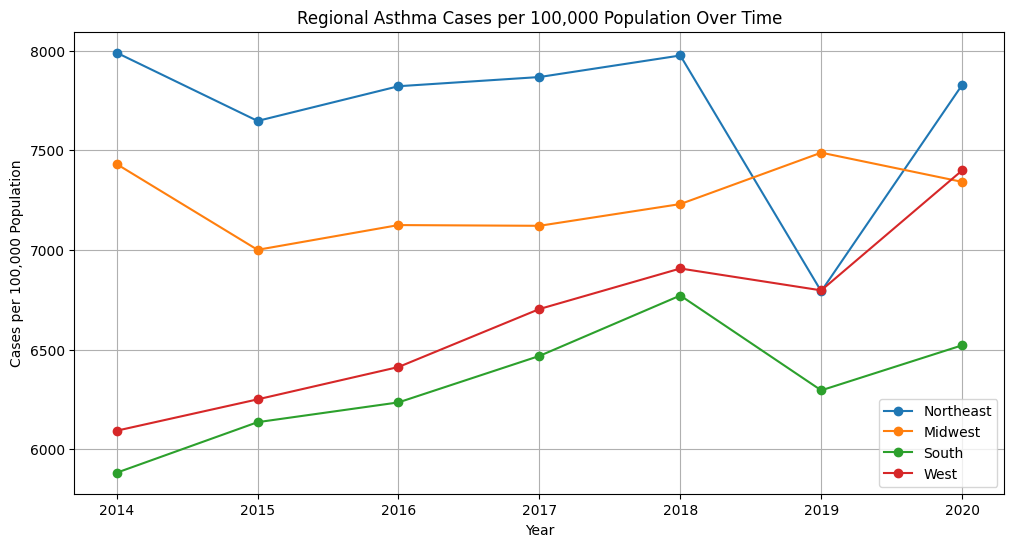

In [8]:
# Define regions
regions = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey'],
    'Midwest': ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa'],
    'South': ['Delaware', 'Maryland', 'Virginia', 'West Virginia', 'Kentucky', 'North Carolina', 'South Carolina', 'Tennessee', 'Georgia', 'Florida', 'Alabama', 'Mississippi', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']
}

# Add region column to dataframes
def add_region(state):
    for region, states in regions.items():
        if state in states:
            return region
    return 'Other'

asthma_df['Region'] = asthma_df['State'].apply(add_region)

# Load population data
population_df = pd.read_csv('./nst-est2020.csv')

# Calculate regional per capita rates
regional_totals = asthma_df.groupby(['Region', 'Year'])['Total'].sum().reset_index()
# First add region column to population data
population_df['Region'] = population_df['NAME'].apply(add_region)

# Then calculate regional population totals
regional_population = population_df.groupby('Region')['POPESTIMATE2020'].sum().reset_index()

regional_per_capita = pd.merge(regional_totals, regional_population, on='Region')
regional_per_capita['Cases_Per_Capita'] = regional_per_capita['Total'] / regional_per_capita['POPESTIMATE2020'] * 100000

# Plot regional trends
plt.figure(figsize=(12, 6))
for region in regions.keys():
    data = regional_per_capita[regional_per_capita['Region'] == region]
    plt.plot(data['Year'], data['Cases_Per_Capita'], marker='o', label=region)

plt.title('Regional Asthma Cases per 100,000 Population Over Time')
plt.xlabel('Year')
plt.ylabel('Cases per 100,000 Population')
plt.legend()
plt.grid(True)
plt.show()

## 2. State Rankings Analysis

In [10]:
# Calculate per capita rates using 2020 population estimates
state_metrics = asthma_df[asthma_df['Year'] == 2020].copy()

# Merge with population data to get 2020 population
state_metrics = pd.merge(
    state_metrics,
    population_df[['NAME', 'POPESTIMATE2020']],
    left_on='State',
    right_on='NAME',
    how='left'
)

# Calculate asthma rate per 100k population
state_metrics['Asthma_Rate'] = state_metrics['Total'] / state_metrics['POPESTIMATE2020'] * 100000

# Get top and bottom states
print("States with Highest Asthma Rates (2020):")
print(state_metrics.nlargest(5, 'Asthma_Rate')[['State', 'Asthma_Rate']])
print("\nStates with Lowest Asthma Rates (2020):")
print(state_metrics.nsmallest(5, 'Asthma_Rate')[['State', 'Asthma_Rate']])

States with Highest Asthma Rates (2020):
            State  Asthma_Rate
48  West Virginia  9805.707908
39   Rhode Island  9761.381104
29  New Hampshire  9303.617500
17       Kentucky  8836.515978
45        Vermont  8788.203039

States with Lowest Asthma Rates (2020):
           State  Asthma_Rate
43         Texas  5508.685930
9        Florida  5874.047177
27      Nebraska  5889.080654
18     Louisiana  5956.771958
41  South Dakota  6047.829267


## 3. Correlation Analysis

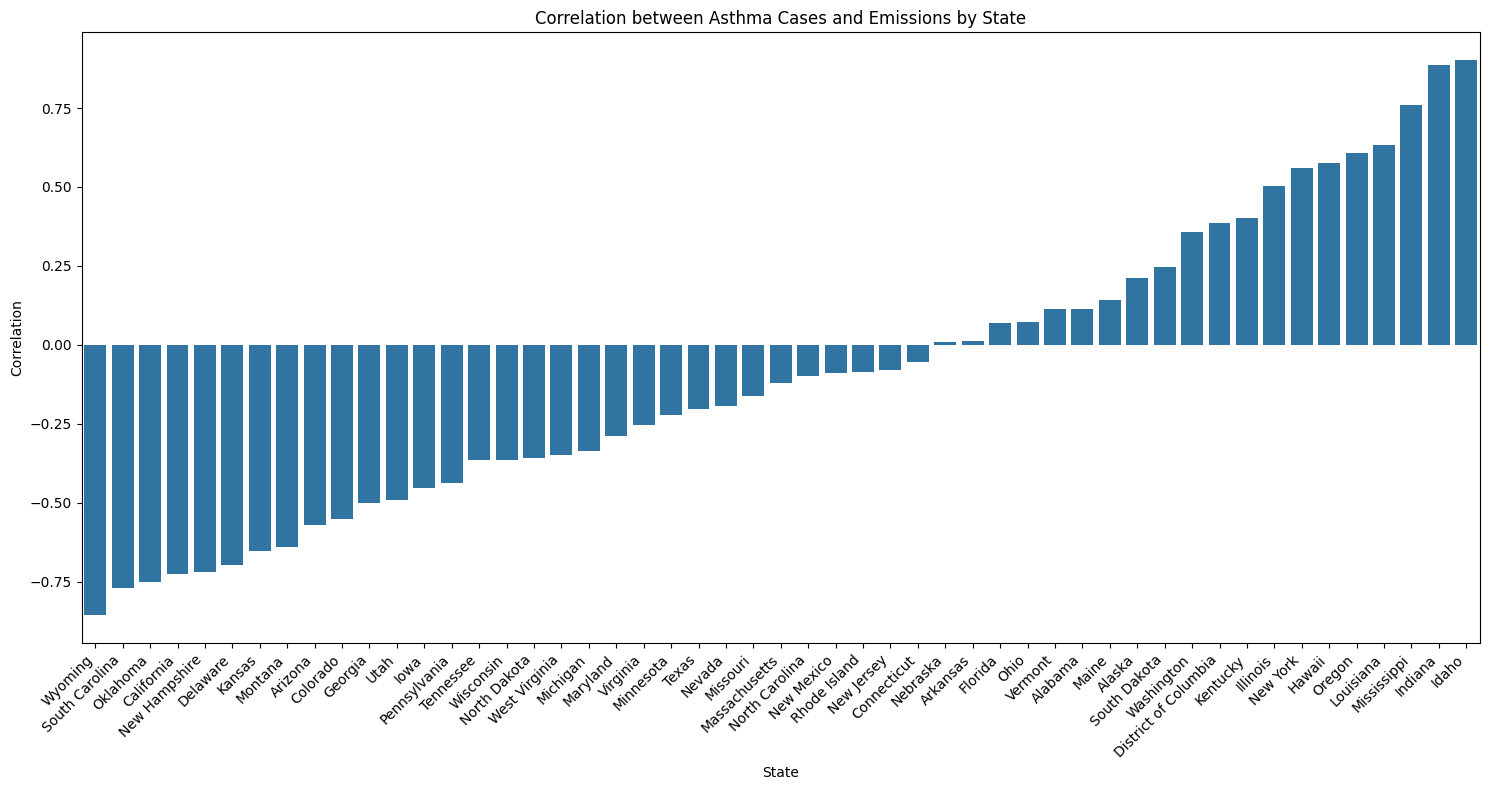

In [11]:
# Prepare emissions data
emissions_total = emissions_df[emissions_df['sector-name'] == 'Total carbon dioxide emissions from all sectors']
emissions_total = emissions_total[emissions_total['fuel-name'] == 'All Fuels']

# Merge datasets for correlation analysis
merged_df = pd.merge(
    asthma_df,
    emissions_total[['year', 'state-name', 'value']],
    left_on=['Year', 'State'],
    right_on=['year', 'state-name']
)

# Calculate correlation by state
correlations = []
for state in merged_df['State'].unique():
    state_data = merged_df[merged_df['State'] == state]
    if len(state_data) > 2:  # Need at least 3 points for correlation
        corr = stats.pearsonr(state_data['Total'], state_data['value'])[0]
        correlations.append({'State': state, 'Correlation': corr})

corr_df = pd.DataFrame(correlations)

# Plot correlation heatmap
plt.figure(figsize=(15, 8))
sns.barplot(data=corr_df.sort_values('Correlation'), x='State', y='Correlation')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation between Asthma Cases and Emissions by State')
plt.tight_layout()
plt.show()

## 4. Seasonal Analysis

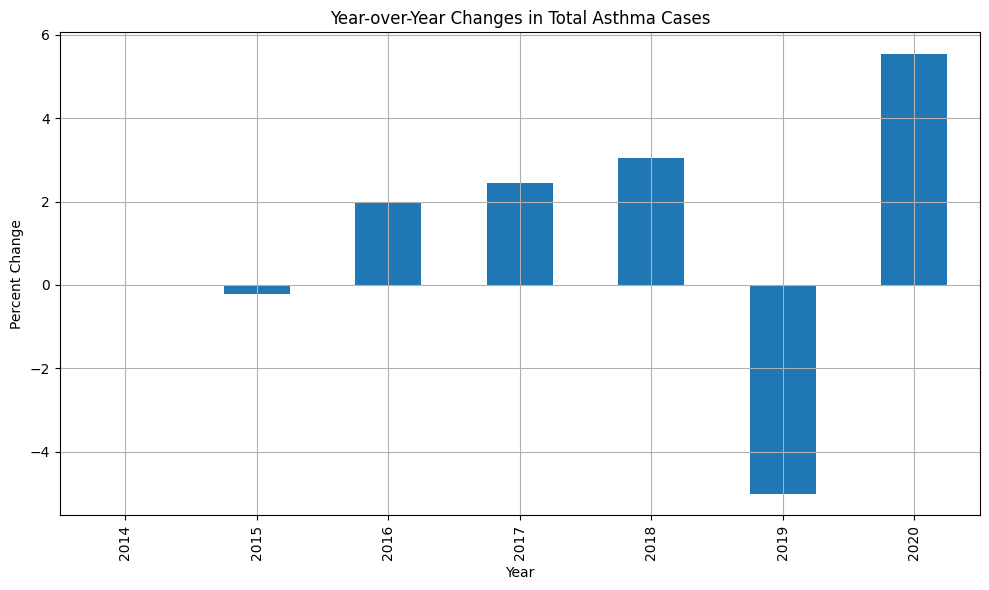

In [13]:
# Group data by year and calculate year-over-year changes
yearly_changes = asthma_df.groupby('Year')['Total'].sum().pct_change() * 100

plt.figure(figsize=(10, 6))
yearly_changes.plot(kind='bar')
plt.title('Year-over-Year Changes in Total Asthma Cases')
plt.xlabel('Year')
plt.ylabel('Percent Change')
plt.grid(True)
plt.tight_layout()
plt.show()